In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import cyrtranslit
from sklearn import preprocessing, model_selection, metrics, feature_selection, ensemble, linear_model, neural_network
from sklearn.pipeline import Pipeline
import lightgbm as lgb
color = sns.color_palette()
%matplotlib inline

In [3]:
train = pd.read_pickle('../../train.pkl',compression='zip')

In [4]:
features = pd.read_pickle('../4.NLP Discretized Term Decomposition/allfeatures.pkl',compression='zip')

In [205]:
y = train.deal_probability
X_dev,X_val,y_dev,y_val = model_selection.train_test_split(features,y)

# LGB

In [289]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
lgtrain = lgb.Dataset(X_dev, label=y_dev)
lgval = lgb.Dataset(X_val, label=y_val)
evals_result = {}

In [290]:
gb = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.220809
[40]	valid_0's rmse: 0.218394
[60]	valid_0's rmse: 0.217521
[80]	valid_0's rmse: 0.217015
[100]	valid_0's rmse: 0.216741
[120]	valid_0's rmse: 0.216455
[140]	valid_0's rmse: 0.216308
[160]	valid_0's rmse: 0.216188
[180]	valid_0's rmse: 0.216099
[200]	valid_0's rmse: 0.216038
[220]	valid_0's rmse: 0.215973
[240]	valid_0's rmse: 0.215884
[260]	valid_0's rmse: 0.215837
[280]	valid_0's rmse: 0.215795
[300]	valid_0's rmse: 0.215734
[320]	valid_0's rmse: 0.215696
[340]	valid_0's rmse: 0.215659
[360]	valid_0's rmse: 0.215627
[380]	valid_0's rmse: 0.215579
[400]	valid_0's rmse: 0.215549
[420]	valid_0's rmse: 0.215537
[440]	valid_0's rmse: 0.215506
[460]	valid_0's rmse: 0.215478
[480]	valid_0's rmse: 0.21546
[500]	valid_0's rmse: 0.215443
[520]	valid_0's rmse: 0.21542
[540]	valid_0's rmse: 0.215394
[560]	valid_0's rmse: 0.215377
[580]	valid_0's rmse: 0.215364
[600]	valid_0's rmse: 0.215333
[620]	valid_0

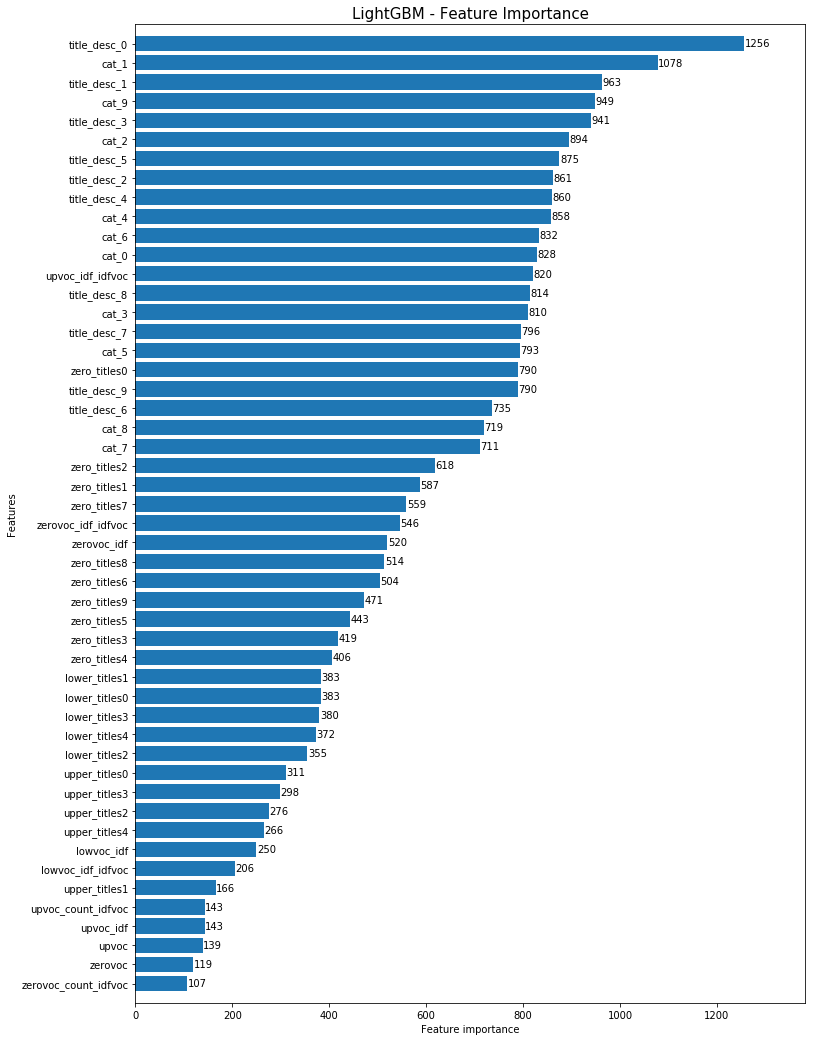

In [292]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(gb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [294]:
pred = gb.predict(X_val, num_iteration=gb.best_iteration)

In [295]:
print('Less than zero:',sum(pred<0))
print('Over one:',sum(pred>1))

Less than zero: 5273
Over one: 45


# Limiting Values to Target Range

In [296]:
pred[pred>1] = 1
pred[pred<0] = 0

In [297]:
metrics.mean_squared_error(y_val,pred)**0.5

0.21516314857496452

In [298]:
residual = y_val-pred

# Residual Analysis

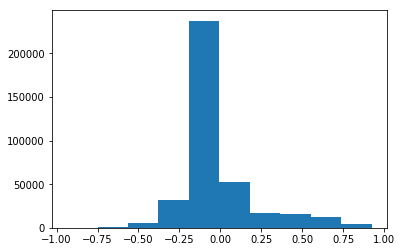

In [299]:
plt.hist(residual)
plt.show()

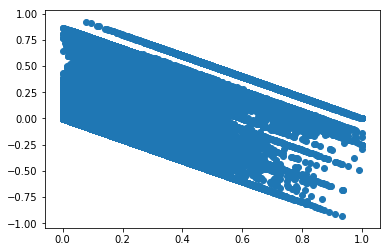

In [300]:
plt.scatter(pred,residual)
plt.show()

# MLPRegressor

- Default values were `tol=0.0001` and `n_iter_no_change=10`. It first ran until these were met and had a good score, but lower than LGBM. I then lowered the tolerance and increased the n_iterations, to allow it more time to improve scores. At that point, it ran for about an hour and score improved further. Still below LGBM though.

In [245]:
mlp = neural_network.MLPRegressor(verbose=True,
                                  hidden_layer_sizes=(128,1),
                                  n_iter_no_change=20,
                                  tol=0.00001
                                 )

In [246]:
mlp.fit(X_dev,y_dev)

Iteration 1, loss = 0.06567249
Iteration 2, loss = 0.03386262
Iteration 3, loss = 0.02920050
Iteration 4, loss = 0.02409196
Iteration 5, loss = 0.02394845
Iteration 6, loss = 0.02388316
Iteration 7, loss = 0.02384528
Iteration 8, loss = 0.02380976
Iteration 9, loss = 0.02378897
Iteration 10, loss = 0.02377594
Iteration 11, loss = 0.02374868
Iteration 12, loss = 0.02373989
Iteration 13, loss = 0.02372324
Iteration 14, loss = 0.02370687
Iteration 15, loss = 0.02370380
Iteration 16, loss = 0.02371675
Iteration 17, loss = 0.02368156
Iteration 18, loss = 0.02368404
Iteration 19, loss = 0.02367936
Iteration 20, loss = 0.02367451
Iteration 21, loss = 0.02367947
Iteration 22, loss = 0.02365671
Iteration 23, loss = 0.02367303
Iteration 24, loss = 0.02366101
Iteration 25, loss = 0.02365315
Iteration 26, loss = 0.02365619
Iteration 27, loss = 0.02364916
Iteration 28, loss = 0.02364159
Iteration 29, loss = 0.02364640
Iteration 30, loss = 0.02363690
Iteration 31, loss = 0.02363001
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(128, 1), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=1e-05,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [306]:
pred = mlp.predict(X_val)

In [307]:
print('Less than zero:',sum(pred<0))
print('Over one:',sum(pred>1))

Less than zero: 3414
Over one: 0


In [308]:
pred[pred>1] = 1
pred[pred<0] = 0

In [309]:
metrics.mean_squared_error(y_val,pred)**0.5

0.21713725679918144

# Keras

In [238]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K

In [256]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=52))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.fit(X_dev,y_dev,epochs=30,verbose=2)

Epoch 1/30
 - 81s - loss: 0.0513 - acc: 0.6481
Epoch 2/30
 - 74s - loss: 0.0483 - acc: 0.6487
Epoch 3/30
 - 90s - loss: 0.0482 - acc: 0.6488
Epoch 4/30
 - 77s - loss: 0.0481 - acc: 0.6488
Epoch 5/30
 - 78s - loss: 0.0481 - acc: 0.6488
Epoch 6/30
 - 79s - loss: 0.0480 - acc: 0.6488
Epoch 7/30
 - 88s - loss: 0.0480 - acc: 0.6488
Epoch 8/30
 - 76s - loss: 0.0480 - acc: 0.6488
Epoch 9/30
 - 92s - loss: 0.0480 - acc: 0.6487
Epoch 10/30
 - 88s - loss: 0.0479 - acc: 0.6487
Epoch 11/30
 - 81s - loss: 0.0479 - acc: 0.6487
Epoch 12/30
 - 76s - loss: 0.0479 - acc: 0.6487
Epoch 13/30
 - 81s - loss: 0.0479 - acc: 0.6487
Epoch 14/30
 - 80s - loss: 0.0479 - acc: 0.6487
Epoch 15/30
 - 82s - loss: 0.0479 - acc: 0.6487
Epoch 16/30
 - 90s - loss: 0.0479 - acc: 0.6488
Epoch 17/30
 - 87s - loss: 0.0479 - acc: 0.6487
Epoch 18/30
 - 86s - loss: 0.0479 - acc: 0.6487
Epoch 19/30
 - 86s - loss: 0.0479 - acc: 0.6488
Epoch 20/30
 - 93s - loss: 0.0479 - acc: 0.6487
Epoch 21/30
 - 95s - loss: 0.0479 - acc: 0.6487
E

In [312]:
pred = model.predict(X_val)

In [313]:
print('Less than zero:',sum(pred<0))
print('Over one:',sum(pred>1))

Less than zero: [0]
Over one: [92]


In [314]:
pred[pred>1] = 1
pred[pred<0] = 0

In [315]:
metrics.mean_squared_error(y_val,pred)**0.5

0.21853347128931533

# RandomForest

In [271]:
rf = ensemble.RandomForestRegressor(
    n_estimators=100,
    verbose=10
)

In [272]:
rf.fit(X_val,y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.3s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


building tree 5 of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s


building tree 6 of 100


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.2min remaining:    0.0s


building tree 7 of 100


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.5min remaining:    0.0s


building tree 8 of 100


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.9min remaining:    0.0s


building tree 9 of 100


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.3min remaining:    0.0s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 36.2min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=10,
           warm_start=False)

In [273]:
pred = rf.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   17.1s finished


In [274]:
print('Less than zero:',sum(pred<0))
print('Over one:',sum(pred>1))

Less than zero: 0
Over one: 0


In [275]:
metrics.mean_squared_error(y_val,pred)**0.5

0.08302533927565796

In [276]:
metrics.mean_squared_error(y_val,pred)

0.0068932069618381124

In [277]:
metrics.r2_score(y_val,pred)

0.8978347240344311

- Cross Validation takes too long with RandomForests. It has to rebuild the trees.

In [286]:
import pickle

In [288]:
pickle.dump(rf, open('random_forest', 'wb'))

In [301]:
pickle.dump(gb, open('light_gbm', 'wb'))

In [310]:
pickle.dump(mlp, open('mlpregressor', 'wb'))

In [316]:
pickle.dump(model, open('keras', 'wb'))

In [304]:
X_val.to_pickle('X_val.pkl')
y_val.to_pickle('y_val.pkl')
X_dev.to_pickle('X_dev.pkl')
y_dev.to_pickle('y_dev.pkl')